In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical,plot_model

import numpy as np
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
train_datasets = "/content/drive/MyDrive/Brain/Training"
validation_datasets = "/content/drive/MyDrive/Brain/Testing"

In [ ]:
batch_size = 64
image_size = 224

In [ ]:
def prepare_the_datasets(train_datasets, validation_datasets, batch_size, image_size):
    train_datasets_generator = ImageDataGenerator(rescale=1./255,
                                                  shear_range = 0.2,
                                                  zoom_range = 0.2,
                                                  horizontal_flip = True,
                                                  vertical_flip= True,
                                                  width_shift_range=0.3,
                                                  fill_mode = "nearest")
    validation_datasets_generator = ImageDataGenerator(rescale=1.0/255)
    train_datasets_generator_data = train_datasets_generator.flow_from_directory(
        batch_size = batch_size,
        directory = train_datasets,
        shuffle = True,
        target_size = (image_size, image_size),
        class_mode = "categorical"
    )
    validation_datasets_generator_data = validation_datasets_generator.flow_from_directory(
        batch_size = batch_size,
        directory = validation_datasets,
        shuffle = True,
        target_size = (image_size, image_size),
        class_mode = "categorical"
    )
    return train_datasets_generator_data, validation_datasets_generator_data

In [ ]:
train_data , validation_data = prepare_the_datasets(train_datasets, validation_datasets, batch_size, image_size)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
densenet= tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    pooling=None,
    input_shape=(224,224,3)
)

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
for layer in densenet.layers:
    layer.trainable= False

In [ ]:
""" Creates the top or head of the model that will be placed on top of the layers """

def addTopModel(bottom_model, num_class, D=64):
    top_model= bottom_model.output
    top_model= Flatten(name="flatten") (top_model)
    top_model= Dense(D, activation="relu") (top_model)
    top_model= Dropout(0.2) (top_model)
    top_model= Dense(num_class, activation="softmax") (top_model)
    return top_model

In [ ]:
num_classes= 4
Fc_Head= addTopModel(densenet, num_classes)
model= Model(inputs= densenet.input, outputs= Fc_Head)

In [ ]:
checkpoint= ModelCheckpoint("/Trained Models/densenet101.h5",
                            monitor= "val_loss",
                            mode= "min",
                            save_best_only= True,
                            verbose=1)

earlystop= EarlyStopping(monitor= "val_loss",
                         min_delta= 0,
                         patience= 10,
                         verbose=1,
                         restore_best_weights= True)


reduce_lr= ReduceLROnPlateau(monitor= "val_loss",
                         factor=0.1,
                         patience= 5,
                         verbose=1,
                         min_delta= 0.00001)


callbacks=[earlystop, checkpoint, reduce_lr]

In [ ]:
model.compile(loss= 'categorical_crossentropy',
              optimizer= Adam(learning_rate=0.0001),
              metrics= ['accuracy'])

In [ ]:
nb_train_samples= 2870
nb_validation_samples= 394
epochs= 30
batch_size= 64

history= model.fit(train_data,
                   steps_per_epoch= nb_train_samples//batch_size,
                   epochs= epochs,
                   callbacks=callbacks,
                   validation_data= validation_data,
                   validation_steps= nb_validation_samples//batch_size,
                    shuffle= True)

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 1.1942 - accuracy: 0.5071 
Epoch 1: val_loss improved from inf to 1.32698, saving model to /Trained Models/densenet101.h5
44/44 [==============================] - 1033s 23s/step - loss: 1.1942 - accuracy: 0.5071 - val_loss: 1.3270 - val_accuracy: 0.4427 - lr: 1.0000e-04
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 0.7435 - accuracy: 0.6803 
Epoch 2: val_loss improved from 1.32698 to 1.32066, saving model to /Trained Models/densenet101.h5
44/44 [==============================] - 1002s 23s/step - loss: 0.7435 - accuracy: 0.6803 - val_loss: 1.3207 - val_accuracy: 0.4792 - lr: 1.0000e-04
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.7455 
Epoch 3: val_loss did not improve from 1.32066
44/44 [==============================] - 993s 23s/step - loss: 0.6494 - accuracy: 0.7455 - val_loss: 1.4053 - val_accuracy: 0.5234 - lr: 1.0000e-04
Epoch 4/30
44/44 [==========

In [ ]:
model_evaluation= model.evaluate(validation_data, batch_size = batch_size)

7/7 [==============================] - 115s 16s/step - loss: 1.0885 - accuracy: 0.6751


In [ ]:
# Model Saving on directory

model.save("/content/drive/MyDrive/Brain/working/densenet101.h5")

In [ ]:
import numpy as np

def plot_training_curves(history):
    loss= np.array(history.history['loss'])
    val_loss= np.array(history.history['val_loss'])

    accuracy= np.array(history.history['accuracy'])
    val_accuracy= np.array(history.history['val_accuracy'])

    epochs= range(len(history.history['loss']))

    fig, (ax1, ax2)= plt.subplots(1,2,figsize=(10,3))

    #plot loss
    ax1.plot(epochs, loss, label='traing_loss', marker='o')

    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs,loss, val_loss, where=(loss>val_loss),color='C0',alpha=0.3,interpolate=True)
    ax1.fill_between(epochs,loss, val_loss, where=(loss<val_loss),color='C1',alpha=0.3,interpolate=True)

    ax1.set_title('Loss(Lower Means Better)',fontsize= 16)
    ax1.set_xlabel('Epochs', fontsize=10)

    ax1.legend()

    #plot Accuracy
    ax2.plot(epochs, accuracy, label='traing_accuracy', marker='o')

    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy>val_accuracy),color='C0',alpha=0.3,interpolate=True)
    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy<val_accuracy),color='C1',alpha=0.3,interpolate=True)

    ax2.set_title('Accuracy(Higher Means Better)',fontsize= 16)
    ax2.set_xlabel('Epochs', fontsize=10)

    ax2.legend()

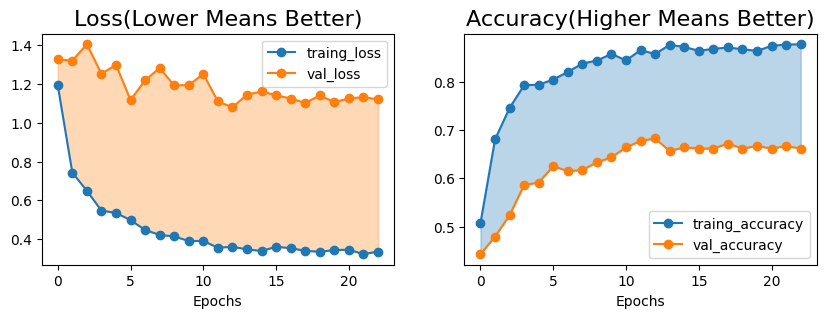

In [ ]:
plot_training_curves(history)

In [ ]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
img= image.load_img("/content/drive/MyDrive/Brain/Testing/no_tumor/image(10).jpg",target_size=(224,224))

x= image.img_to_array(img)
x=x/255
x= np.expand_dims(x, axis=0)
img_data=preprocess_input(x)
img_data.shape
preds= model.predict(x)
preds= np.argmax(preds, axis=1)
if preds==1:
    preds="The image is glima Tumor"
elif preds==2:
    preds="The image is meningioma Tumor"
elif preds==3:
    preds="The image is No Tumor"
else:
    preds="The image is pituitary tumor"
print(preds)

1/1 [==============================] - 6s 6s/step
The image is meningioma Tumor


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Brain/working/densenet101.h5')
dataset_path = '/content/drive/MyDrive/Brain/Testing//'
class_folders = os.listdir(dataset_path)
for class_folder in class_folders:
    print(f'Class: {class_folder}')

Class: meningioma_tumor
Class: pituitary_tumor
Class: no_tumor
Class: glioma_tumor


In [ ]:
from IPython.display import display, Markdown

1/1 [==============================] - 4s 4s/step


<h3 style='color:green;'>Predicted class: meningioma_tumor</h3>

<h3 style='color:blue;'>Confidence: 99.91%</h3>

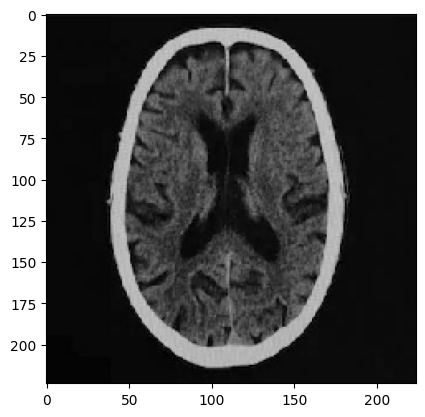

In [ ]:
imagePath = "/content/drive/MyDrive/Brain/Testing/no_tumor/image(103).jpg"

img = image.load_img(imagePath, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

predictions = model.predict(x)

class_labels = ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']
predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

markdown_text = f"<h3 style='color:green;'>Predicted class: {predicted_class_label}</h3>"
display(Markdown(markdown_text))

markdown_text2 = f"<h3 style='color:blue;'>Confidence: {confidence*100:.2f}%</h3>"
display(Markdown(markdown_text2))

plt.imshow(img)
plt.show()